In [4]:
import numpy as np
import torch

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Projects\news-classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Exploration:

In [5]:
import pandas as pd

df = pd.read_csv('../data/raw/train.csv')
df.head()                       # returns the first 5 rows of pandas DataFrame 'df'

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [6]:
df.shape

(120000, 3)

[!] &nbsp; *Note.* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; We have 120 000 tuples or a DataFrame with 120 000 rows and 3 columns for `Class Index `, `Title`, and `Description`.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


Then we do not have any missing values (all tuples have max info).

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.countplot(df['Class Index'])
# plt.xlabel('Class')                 # NOTE: DO NOT run again (takes forever)

Then also notice that we do not have a class imbalance (equal representation in data)

### Data Preprocessing:

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Here, `bert-base-cased` refers to the base **BERT** model trained on *cased* (upper and lowercase texts) where as `bert-base-uncased` refers to the base BERT model trained on only lowercase texts. The cased version is recommended.

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

sample_txt = 'I am excited for this semester at the University of Florida. Go Gators!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f"Sentence:  {sample_txt}")
print(f"Tokens:    {tokens}")
print(f"Token IDS: {token_ids}")

Sentence:  I am excited for this semester at the University of Florida. Go Gators!
Tokens:    ['I', 'am', 'excited', 'for', 'this', 'semester', 'at', 'the', 'University', 'of', 'Florida', '.', 'Go', 'G', '##ators', '!']
Token IDS: [146, 1821, 7215, 1111, 1142, 14594, 1120, 1103, 1239, 1104, 2631, 119, 3414, 144, 11664, 106]


*Special Tokens*

In [10]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

&nbsp;&nbsp;&nbsp;&nbsp;&rarr; Marker for ending of a sentence.

In [9]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

&nbsp;&nbsp;&nbsp;&nbsp;&rarr; Marker for classification added to the start of a sentence.

In [10]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

&nbsp;&nbsp;&nbsp;&nbsp;&rarr; Padding token.

In [11]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

&nbsp;&nbsp;&nbsp;&nbsp;&rarr; Unknown token (word or subword not present in `bert-base-cased` original training dataset).

In [11]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,    # referring to adding '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',         # return PyTorch tensors
)

encoding.keys()

# dict_keys(['input_ids', 'attention_mask'])

KeysView({'input_ids': tensor([[  101,   146,  1821,  7215,  1111,  1142, 14594,  1120,  1103,  1239,
          1104,  2631,   119,  3414,   144, 11664,   106,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])})

Notice the presence of *special tokens* after running the `sample_txt` through the `tokenizer` method:
 + '[CLS]' ~ (101) at the start
 + '[SEP]' ~ (102) at the end and
 + '[PAD]' ~ (0) padding indices 17 to 31 with zeros

We have a Tensor storing token ids and padded to a length of 32.

In [12]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  1821,  7215,  1111,  1142, 14594,  1120,  1103,  1239,
         1104,  2631,   119,  3414,   144, 11664,   106,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

And we have our attention mask, a binary Tensor used for informing the model which tokens in a sequence should be considered during the **attention mechanism** and which should be ignored.

In [13]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Inversing tokenization (text -> token ids), we return to our original text-form sequence of tokens.

In [14]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'am',
 'excited',
 'for',
 'this',
 'semester',
 'at',
 'the',
 'University',
 'of',
 'Florida',
 '.',
 'Go',
 'G',
 '##ators',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

*Choosing Sequence Length*

Here, `token_lens` is used to store the ordered lengths of descriptions from our training data.

In [15]:
token_lens = []

for txt in df['Description']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

Plotting the distribution,

Text(0.5, 9.444444444444438, 'Token count')

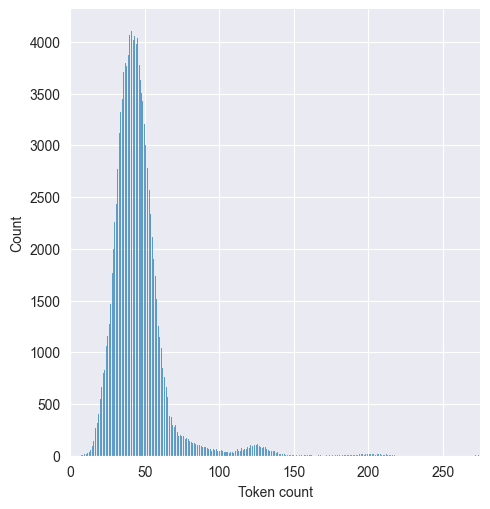

In [18]:
sns.displot(token_lens)
plt.xlim([0, 275])
plt.xlabel('Token count')

We notice that `Description`s are between 40 and 50 tokens on average and upwards of 150 tokens captures nearly all `Description`s. Therefore we choose a `MAX_LEN` of 150 to balance accuracy and efficiency.

In [19]:
MAX_LEN = 150

*Creating custom Dataset class*

In [21]:
from torch.utils.data import Dataset

class NewsArticlesDataset(Dataset):

    def __init__(self, descriptions, targets, tokenizer, max_len):
        self.descriptions = descriptions    # array of inputs
        self.targets = targets              # array of outputs
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, item):
        description = str(self.descriptions[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'description_text': description,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding ['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

[!] &nbsp; *Note.* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Since our `NewsArticleDataset` class inherits from the `Dataset` class of `torch.utils.data`, note that this class requires the following methods:
+ `__len__(self)`: this method returns the total number of samples in the corresponding dataset.
+ `__getitem__(self, item)`: this method enables indexing into the corresponding dataset using `item` parameter, allowing for retrieval of specific samples and their corresponding label (or target).

*Splitting the data*

In [20]:
from sklearn.model_selection import train_test_split

# df_train, df_test = train_test_split(
#     df,
#     test_size=0.1,
#     random_state=RANDOM_SEED
# )
#
# df_val, df_test = train_test_split(
#     df_test,
#     test_size=0.5,
#     random_state=RANDOM_SEED
# )

However, our datasets have been (conveniently) split into `train.csv` and `test.csv` by the file provider.

In [24]:
import pandas as pd

df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

train_rows = len(df_train)
test_rows = len(df_test)
total_rows = train_rows + test_rows

train_ratio = train_rows / total_rows
test_ratio = test_rows / total_rows

print(f"Train-Test data split: {train_ratio * 100}%, {test_ratio * 100}%")

Train-Test data split: 94.04388714733543%, 5.956112852664576%


In [25]:
from sklearn.model_selection import train_test_split

# extract ~ 5% of training data for validation (for fine-tuning hyperparams)
df_train, df_val = train_test_split(
    df_train,
    test_size=0.05,
    random_state=RANDOM_SEED,
)

train_rows = len(df_train)
val_rows = len(df_val)
test_rows = len(df_test)

total_rows = train_rows + val_rows + test_rows

train_ratio = train_rows / total_rows
val_ratio = val_rows / total_rows
test_ratio = test_rows / total_rows

print(f"Train-Test data split: {train_ratio * 100}%, {val_ratio * 100}%, {test_ratio * 100}%")

Train-Test data split: 89.34169278996865%, 4.702194357366771%, 5.956112852664576%


*Recall*. &nbsp;&nbsp;&nbsp;&nbsp; ML Process can be broken in the following stages:
1. Training (where model learns patterns, relationships, and parameters from training data)
2. Validation (used for fine-tuning of hyperparameters and selecting best performing model architecture)
3. Testing (dataset independent of training and validation datasets; purpose of providing unbiased evaluation of the final selected model's performance on "unknown" data, a simulation for real-world use)

*Data Loaders*

In [26]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsArticlesDataset(
        descriptions=df['Description'].to_numpy(),
        targets=df['Class Index'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0               # NOTE: Causes errors on Windows unless zero
    )

[!] &nbsp; *Note.* &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; PyTorch's `DataLoader` module has a well-known issue where the `num_workers` parameter must be set to zero on Windows devices, otherwise breaking errors ensue.

In [27]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Taking a closer look at an example batch from our training data loader,

In [28]:
data = next(iter(train_data_loader))

print("Keys in batch:", data.keys())
print("Input IDs shape:", data['input_ids'].shape)
print("Attention mask shape:", data['attention_mask'].shape)
print("Targets shape:", data['targets'].shape)

Keys in batch: dict_keys(['description_text', 'input_ids', 'attention_mask', 'targets'])
Input IDs shape: torch.Size([16, 150])
Attention mask shape: torch.Size([16, 150])
Targets shape: torch.Size([16])


**Topic Classifier Class**

In [44]:
from transformers import BertModel

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

*Recall*. &nbsp;&nbsp;&nbsp;&nbsp; `PRE_TRAINED_MODEL_NAME` corresponds with `bert-base-cased`.

In [53]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask'],
    return_dict=False                           # used to return a tuple
)

Here, `last_hidden_state` is a sqeuence of hidden states of the last layer of the model. The `pooled_output` is obtained by applying the *BertPooler* on `last_hidden_state`.

In [54]:
last_hidden_state.shape

torch.Size([1, 32, 768])

That is we have a tensor 2D (32 x 768) tensor storing 768 hidden states for each of the 32 tokens (limited to 32 previously). We can verify the number of hidden states or hidden units in the feedforward networks with the following:

In [57]:
bert_model.config.hidden_size

768

Lastly, `pooled_output` acts as a summary of the content after passing through the **BERT** model.

In [56]:
pooled_output.shape

torch.Size([1, 768])

*Classifier*

In [60]:
from torch import nn

class TopicClassifier(nn.Module):

    def __init__(self, n_classes):
        super(TopicClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3) # probability of dropping
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )

        output = self.drop(pooled_output)

        return self.out(output)

This class is compromised of two components:
1. `def __init__(self, n_classes)`:
    + `self.bert` represents our pretrained model from which we base the transfer learning off of. BERT provides:
        + 12 transformer layers (`bert-base`)
        + 768-dimensional representations
        + pre-learned linguistic patterns, grammars and some world knowledge
    + `self.drop` represents the *dropout layer* which prevents overfitting by randomly dropping 30% (since `p=0.3`) of neurons (that is randomly zeroing `pooled_output` values) during training.
        + *Note*. &nbsp;&nbsp; process of randomly dropping neurons during training is referred to as **regularization**.
    + `self.out` represents the *classification head* providing a single linear layer with input dimension of 768 (corresponding to **BERT**'s hidden size) and an output dimension corresponding to `n_classes` to classified into.
2. `def forward(self, input_ids, attention_mask)`:
    + takes in a sequence of token ids and an attention mask for a given batch of texts
    + processes through BERT (12 transformer layers)
    + returns:
        + `last_hidden_layer` of form [batch, seq_len, 768] and corresponding to all token representations
        + `pooled_output` of the form [batch, 768], this is the [CLS] token with an additional pooling layer (linear layer + tanh used to further refine given representation).
    + *Note*. &nbsp;&nbsp; The [CLS] token is specifically designed for sentence-level tasks, so it makes sense to use pooled_output.
    + Classification here takes on a linear transformation:
        + [batch, 768] -> [batch, n_classes]

*Creating an Instance of the Model*

First, we'll move an example batch of training data to the GPU.

In [61]:
model = TopicClassifier(4) # for topics of "sports", "business", "sci"/"tech" and                           # "world"
model = model.to(device)

In [62]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention mask shape: {attention_mask.shape}")

Input IDs shape: torch.Size([16, 150])
Attention mask shape: torch.Size([16, 150])


To get the predicted probabilities from our trained model, we apply the `softmax` function to the outputs:

In [64]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1536, 0.1790, 0.4545, 0.2129],
        [0.1384, 0.2446, 0.4745, 0.1425],
        [0.1866, 0.2935, 0.3685, 0.1514],
        [0.1627, 0.1833, 0.4987, 0.1552],
        [0.2639, 0.2690, 0.2722, 0.1949],
        [0.2753, 0.2242, 0.2888, 0.2117],
        [0.1965, 0.2791, 0.3331, 0.1912],
        [0.1867, 0.3664, 0.3460, 0.1009],
        [0.2660, 0.2497, 0.3773, 0.1069],
        [0.1807, 0.2118, 0.3498, 0.2577],
        [0.1575, 0.2162, 0.4669, 0.1593],
        [0.3834, 0.1795, 0.1928, 0.2443],
        [0.2076, 0.3045, 0.4110, 0.0770],
        [0.1661, 0.2758, 0.4606, 0.0974],
        [0.1583, 0.2599, 0.4293, 0.1525],
        [0.2451, 0.2229, 0.3584, 0.1736]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

### Training

In [ ]:
from transformers import AdamWeightDecay as Adam, get_linear_schedule_with_warmup

EPOCHS = 10

optimizer = Adam(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
        model,
        data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        n_examples
):
    # TODO